In [1]:
import cdsapi
import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import linregress
import matplotlib.colors as mcolors
import time
from cartopy.util import add_cyclic_point

### Optional: Download and process data

In [4]:
# Download data from CDS
dataset = "reanalysis-era5-single-levels-monthly-means"
request = {
    "product_type": ["monthly_averaged_reanalysis"],
    "variable": [
        "vertical_integral_of_eastward_water_vapour_flux",
        "vertical_integral_of_northward_water_vapour_flux",
        "vertically_integrated_moisture_divergence"
    ],
    "year": [
        "1980", "1981", "1982",
        "1983", "1984", "1985",
        "1986", "1987", "1988",
        "1989", "1990", "1991",
        "1992", "1993", "1994",
        "1995", "1996", "1997",
        "1998", "1999", "2000",
        "2001", "2002", "2003",
        "2004", "2005", "2006",
        "2007", "2008", "2009",
        "2010", "2011", "2012",
        "2013", "2014", "2015",
        "2016", "2017", "2018",
        "2019", "2020", "2021",
        "2022"
    ],
    "month": ["03", "04", "05"],
    "time": ["00:00"],
    "data_format": "netcdf",
    "download_format": "unarchived",
    "area": [90, -180, 0, 180]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

2025-08-29 12:05:04,846 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-08-29 12:05:05,513 INFO Request ID is f41a69a8-9615-43b9-8b17-0846187d5525
2025-08-29 12:05:05,790 INFO status has been updated to accepted
2025-08-29 12:05:15,027 INFO status has been updated to running
2025-08-29 12:05:28,188 INFO status has been updated to accepted
2025-08-29 12:06:23,056 INFO status has been updated to running
2025-08-29 12:07:01,753 INFO status has been updated to successful


a455bc65264790c0202b43a076812868.zip:   0%|          | 0.00/304M [00:00<?, ?B/s]

'a455bc65264790c0202b43a076812868.zip'

In [ ]:
# Filter March/April and calculate trend at each grid cell
def monthly_trend(data, month):
    # Filter only the desired month
    month_data = data.sel(valid_time=data['valid_time'].dt.month == month)
    
    # Extract years as numeric array
    years = month_data['valid_time'].dt.year.values
    years_centered = years - years.mean()  # Center for numerical stability
    
    # Reshape years for polyfit: shape (N_time,)
    # Data shape: (time, ...) where ... are spatial dims
    
    # Move time axis to front and flatten spatial dims
    y = month_data.values
    orig_shape = y.shape[1:]  # all dims except time
    y_reshaped = y.reshape(len(years), -1)  # shape: (time, npoints)
    
    # Prepare array for slopes
    slopes = np.full(y_reshaped.shape[1], np.nan)
    
    # Loop over each spatial point (or use a vectorized approach)
    for i in range(y_reshaped.shape[1]):
        valid = np.isfinite(y_reshaped[:, i])
        if np.sum(valid) > 1:
            # Fit line: np.polyfit returns [slope, intercept]
            p = np.polyfit(years_centered[valid], y_reshaped[valid, i], 1)
            slopes[i] = p[0]
    
    # Reshape slopes back to spatial dims
    slopes = slopes.reshape(orig_shape)
    
    # Create new DataArray with same dims as spatial dims
    trend = xr.DataArray(slopes, dims=month_data.dims[1:], coords={dim: month_data.coords[dim] for dim in month_data.dims[1:]})
    
    return trend


# Apply to each variable for March and April
north_flux = xr.open_dataset('../data/moisture_flux.nc').viwvn
east_flux = xr.open_dataset('../data/moisture_flux.nc').viwve
divergence = xr.open_dataset('../data/moisture_divergence.nc').vimd

# Calculate trends for March (month = 3)
march_trend_north = monthly_trend(north_flux, 3)
march_trend_east = monthly_trend(east_flux, 3)
march_trend_div = monthly_trend(divergence, 3)

# April (month = 4)
april_trend_north = monthly_trend(north_flux, 4)
april_trend_east = monthly_trend(east_flux, 4)
april_trend_div = monthly_trend(divergence, 4)

# Save trends as NetCDF
march_trend_ds = xr.Dataset({
    "northward_flux_trend": march_trend_north,
    "eastward_flux_trend": march_trend_east,
    "divergence_trend": march_trend_div,
})
march_trend_ds.to_netcdf("march_flux_divergence_trend.nc")

april_trend_ds = xr.Dataset({
    "northward_flux_trend": april_trend_north,
    "eastward_flux_trend": april_trend_east,
    "divergence_trend": april_trend_div,
})
april_trend_ds.to_netcdf("april_flux_divergence_trend.nc")


In [3]:
# Total column water vapor
tcwv = xr.open_dataset('/pscratch/sd/s/skygale/dyn-data/single_level_TCWV.nc').tcwv
tcwv = tcwv.sel(valid_time=slice("1980-01", "2022-12"))
tcwv_mam = tcwv.sel(valid_time=tcwv.valid_time.dt.month.isin([3, 4, 5]))

# Lat, lon for TCWV
wv_lats = tcwv_mam.latitude.values
wv_lons = tcwv_mam.longitude.values

start = time.time()
TCWV_maps = tcwv_mam.data.reshape(43, 3, len(wv_lats), len(wv_lons))
print(f"Reshape time: {(time.time() - start)/60:.2f} minutes")

TCWV_da = xr.DataArray(
    TCWV_maps,
    dims=["year", "month", "lat", "lon"],
    coords={
        "year": np.arange(1980, 2023),
        "month": [3, 4, 5],
        "lat": wv_lats,
        "lon": wv_lons
    },
    name="TCWV"
)

print('Shape:', TCWV_da.shape)


Reshape time: 5.06 minutes
Shape: (43, 3, 721, 1440)


In [8]:
# Get trends
def calc_trend(y, time):
    valid = np.isfinite(y)
    if np.sum(valid) < 2:
        return np.nan
    x = time[valid]
    y = y[valid]
    x_centered = x - x.mean()
    slope, _ = np.polyfit(x_centered, y, 1)
    return slope * 10  # per decade

def monthly_trend_fast(data, m, month):
    data_m = data.sel(month=m)
    years = data_m['year']

    trend = xr.apply_ufunc(
        calc_trend,
        data_m,
        years,
        input_core_dims=[["year"], ["year"]],
        output_core_dims=[[]],
        vectorize=True,
        dask="parallelized",  # Enable Dask if available
        output_dtypes=[float],
        keep_attrs=True
    )

    trend.attrs["units"] = "kg$^{2}$ m$^{-2}$ decade$^{-1}$"
    return trend


# Calculate anomalies
climatology = TCWV_da.mean(dim="year")
anomalies = TCWV_da - climatology

months = ["March", "April", "May"]
monthly_trends = {}

for m in range(3, 6):
    month_name = months[m-3]
    print(f"Processing month {month_name}...")
    monthly_trends[m] = monthly_trend_fast(anomalies, m, month_name)

# Stack trends
monthly_trend_stack = xr.concat(
    [monthly_trends[m] for m in range(3, 6)],
    dim=xr.DataArray(months, dims="month", name="month")
)

# Save to netCDF
monthly_trend_stack.to_netcdf("TCWV_anomaly_trends.nc")

Processing month March...
Processing month April...
Processing month May...


RuntimeError: NetCDF: HDF error

### Load data

In [2]:
# Load processed data

# Total column water vapor
tcwv = xr.open_dataset('/pscratch/sd/s/skygale/data/single_level_TCWV.nc').tcwv
tcwv = tcwv.sel(valid_time=slice("1980-01", "2022-12"))
tcwv_mam = tcwv.sel(valid_time=tcwv.valid_time.dt.month.isin([3, 4, 5]))
TCWV_maps = xr.open_dataset('/pscratch/sd/s/skygale/data/TCWV_anomaly_trends.nc').TCWV

# Lat, lon for TCWV
wv_lat = tcwv_mam.latitude.values
wv_lon = tcwv_mam.longitude.values

# Moisture flux and divergence
march_ds = xr.open_dataset("/pscratch/sd/s/skygale/data/march_flux_divergence_trend.nc")
april_ds = xr.open_dataset("/pscratch/sd/s/skygale/data/april_flux_divergence_trend.nc")

march_trend_north, march_trend_east, march_trend_div = march_ds.northward_flux_trend, march_ds.eastward_flux_trend, march_ds.divergence_trend
april_trend_north, april_trend_east, april_trend_div = april_ds.northward_flux_trend, april_ds.eastward_flux_trend, april_ds.divergence_trend

# Lat, lon for moisture flux and divergence
div_lat = march_trend_north.latitude.values
div_lon = march_trend_north.longitude.values

# Surface air temperature
SAT_paths = glob.glob('/pscratch/sd/s/skygale/workspace/training-data/monthly/observations/sat/*.nc')
SAT_data = []
for path in SAT_paths:
    ds = xr.open_dataset(path).DATA
    SAT_data.append(ds)
SAT_maps = np.nanmean(SAT_data, axis=0)[2:5]

# Sea level pressure
SLP_paths = glob.glob('/pscratch/sd/s/skygale/workspace/training-data/monthly/observations/slp/*.nc')
SLP_data = []
for path in SLP_paths:
    ds = xr.open_dataset(path).DATA
    SLP_data.append(ds)
SLP_maps = np.nanmean(SLP_data, axis=0)[2:5] / 100

# Lat, lon for SAT and SLP
lat = ds.lat.values
lon = ds.lon.values

# Check shapes
print('march_trend_north:  ', np.shape(march_trend_north))
print('march_trend_east:   ', np.shape(march_trend_east))
print('march_trend_div:    ', np.shape(march_trend_div))
print('(div_lat, div_lon): ', len(div_lat), len(div_lon))

print('\nTCWV_maps:          ', np.shape(TCWV_maps))
print('(wv_lat, wv_lon):   ', len(wv_lat), len(wv_lon))

print('\nSAT_maps:           ', np.shape(SAT_maps))
print('SLP_maps:           ', np.shape(SLP_maps))
print('(lat, lon):         ', len(lat), len(lon))


march_trend_north:   (361, 1440)
march_trend_east:    (361, 1440)
march_trend_div:     (361, 1440)
(div_lat, div_lon):  361 1440

TCWV_maps:           (3, 721, 1440)
(wv_lat, wv_lon):    721 1440

SAT_maps:            (3, 72, 144)
SLP_maps:            (3, 72, 144)
(lat, lon):          72 144


### Overlay plots

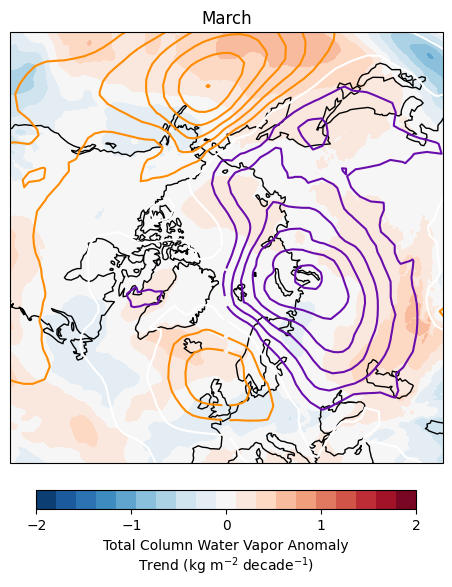

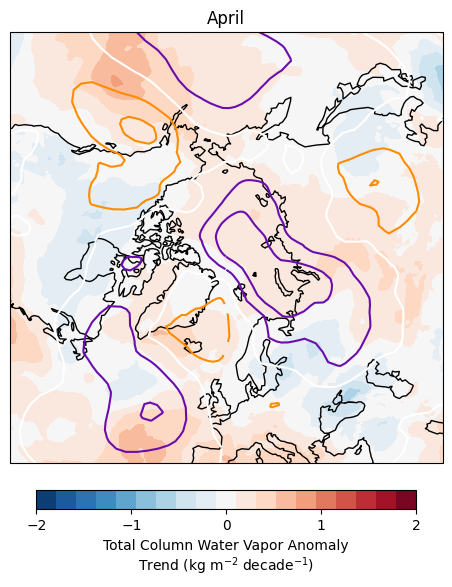

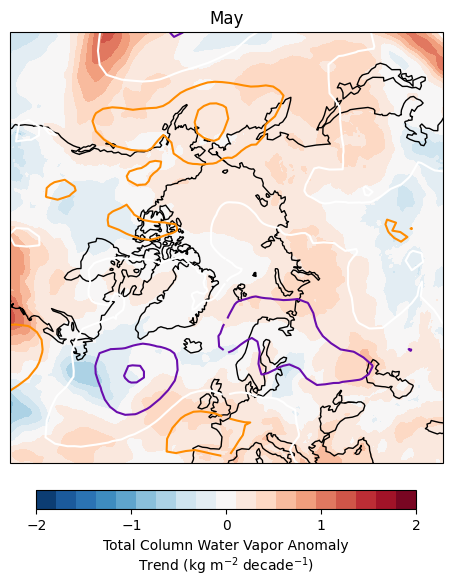

In [13]:
# Overlay SLP (contour lines) on TCWV (filled contours)
months = ["March", "April", "May"]

for month in range(3):
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
    ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())

    # Contours of TCWV
    im = ax.contourf(
        wv_lon, wv_lat,
        TCWV_maps[month],
        cmap="RdBu_r",
        levels=np.linspace(-2, 2, 20),
        transform=ccrs.PlateCarree()
    )

    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=np.linspace(-2, 2, 5), shrink=0.7, pad=0.05)
    cbar.set_label('Total Column Water Vapor Anomaly\nTrend (kg m$^{-2}$ decade$^{-1}$)')

    # Contour lines of SLP
    levels = np.linspace(-4, 4, 17)

    colors = []
    for lev in levels[:-1]:
        if lev < 0:
            colors.append('#6a0dad')
        elif lev >= 0:
            colors.append('#ff8c00')
    
    zero_index = np.where(levels == 0)[0]
    if zero_index.size > 0:
        colors[zero_index[0]] = '#ffffff'
    
    ax.contour(
        lon, lat, SLP_maps[month],
        colors=colors,
        levels=levels,
        linewidths=1.5,
        transform=ccrs.PlateCarree()
    )

    ax.grid(alpha=0.3)
    ax.coastlines()
    ax.set_title(months[month])
    plt.savefig(f'../figures/{months[month]}_TCWV_SLP_Overlay.png', dpi=300)
    plt.show()

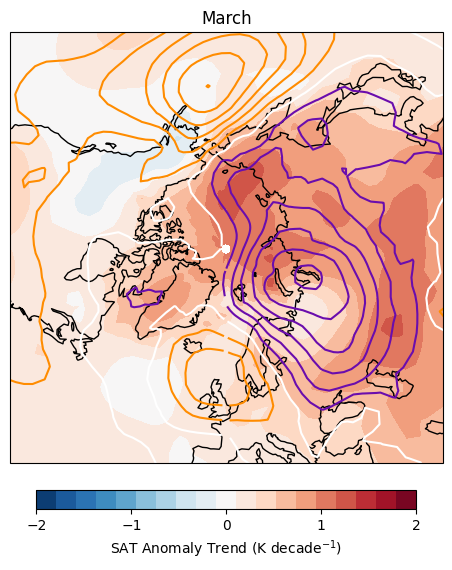

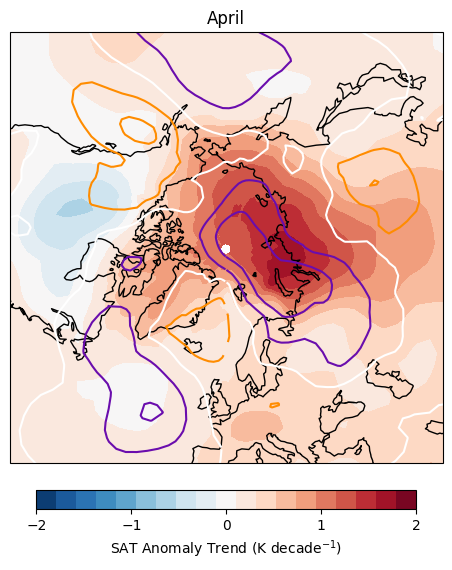

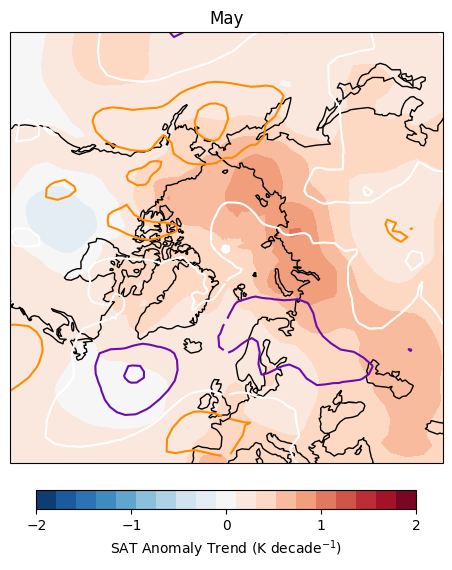

In [10]:
# Overlay SLP (contour lines) on SAT (filled contours)
months = ["March", "April", "May"]

for month in range(3):
    fig, ax = plt.subplots(figsize=(7, 7), subplot_kw={'projection': ccrs.NorthPolarStereo()})
    ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())

    # Contours of SAT
    SAT_map_cyclic, lon_cyclic = add_cyclic_point(SAT_maps[month], coord=lon)

    im = ax.contourf(
        lon_cyclic, lat,
        SAT_map_cyclic,
        cmap="RdBu_r",
        levels=np.linspace(-2, 2, 20),
        transform=ccrs.PlateCarree()
    )

    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=np.linspace(-2, 2, 5), shrink=0.7, pad=0.05)
    cbar.set_label('SAT Anomaly Trend (K decade$^{-1}$)')

    # Contour lines of SLP
    levels = np.linspace(-4, 4, 17)

    colors = []
    for lev in levels[:-1]:
        if lev < 0:
            colors.append('#6a0dad')
        elif lev >= 0:
            colors.append('#ff8c00')
    
    zero_index = np.where(levels == 0)[0]
    if zero_index.size > 0:
        colors[zero_index[0]] = '#ffffff'
    
    ax.contour(
        lon, lat, SLP_maps[month],
        colors=colors,
        levels=levels,
        linewidths=1.5,
        transform=ccrs.PlateCarree()
    )

    ax.grid(alpha=0.3)
    ax.coastlines()
    ax.set_title(months[month])
    plt.savefig(f'../figures/{months[month]}_SAT_SLP_Overlay.png', dpi=300)
    plt.show()

### Moisture flux and divergence plots

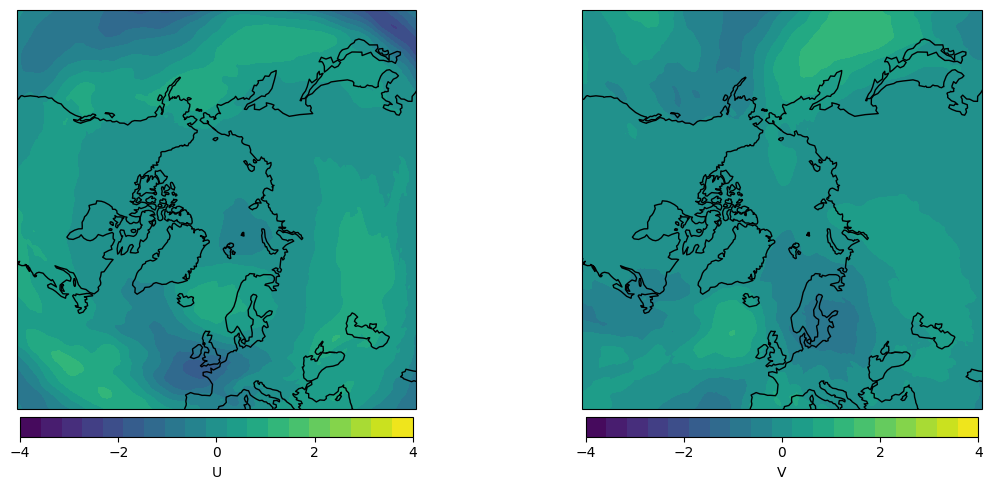

In [3]:
lat = march_trend_east.latitude.values
lon = march_trend_east.longitude.values

fig, axes = plt.subplots(ncols=2, figsize=(12, 5), subplot_kw={'projection': ccrs.NorthPolarStereo()})

im1 = axes[0].contourf(lon, lat, march_trend_east, levels=np.linspace(-4, 4, 20), transform=ccrs.PlateCarree())

im2 = axes[1].contourf(lon, lat, march_trend_north, levels=np.linspace(-4, 4, 20), transform=ccrs.PlateCarree())

for ax in axes:
    ax.coastlines()
    ax.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())

cbar1 = fig.colorbar(im1, ax=axes[0], orientation='horizontal', ticks=np.linspace(-4, 4, 5), fraction=0.046, pad=0.02)
cbar1.set_label("U")

cbar2 = fig.colorbar(im2, ax=axes[1], orientation='horizontal', ticks=np.linspace(-4, 4, 5), fraction=0.046, pad=0.02)
cbar2.set_label("V")

plt.tight_layout()
plt.show()


In [4]:
def plot_quiver_with_contour_polar(east, north, div, month_name):
    # Flip latitude for correct order
    lat = east.latitude.values[::-1]
    lon = east.longitude.values
    Lon, Lat = np.meshgrid(lon, lat)

    # Moisture flux vectors (times 10 for per decade)
    U = east[::-1].values * 10
    V = north[::-1].values * 10

    # Setup projection and figure
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.NorthPolarStereo()})
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(alpha=0.3)

    # Filled contour of divergence
    im = ax.contourf(
        lon, lat, -div[::-1] * 10,
        levels=np.linspace(-1.5, 1.5, 20),
        cmap='RdBu_r',
        transform=ccrs.PlateCarree()
    )

    # Colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', ticks=np.linspace(-1.5, 1.5, 7), shrink=0.7, pad=0.05)
    cbar.set_label('Moisture Convergence (kg m$^{-2}$ decade$^{-1}$)')

    '''
    # Contour lines of SLP
    levels = np.linspace(-4, 4, 17)

    colors = []
    for lev in levels[:-1]:
        if lev < 0:
            colors.append('#6a0dad')
        elif lev >= 0:
            colors.append('#ff8c00')
    
    zero_index = np.where(levels == 0)[0]
    if zero_index.size > 0:
        colors[zero_index[0]] = '#ffffff'
    
    ax.contour(
        slp_lon, slp_lat, slp,
        colors=colors,
        levels=levels,
        linewidths=1,
        transform=ccrs.PlateCarree()
    )
    '''

    # Quiver: Use transform and regrid_shape
    q = ax.quiver(
        Lon, Lat, U, V,
        transform=ccrs.PlateCarree(),
        regrid_shape=20,  # Adjust for arrow density
        scale=300,
        width=0.004,
        headlength=3,
        headwidth=3,
        headaxislength=4,
        color='black'
    )

    # Quiver key
    ax.quiverkey(
        q, 0.65, -0.035, 10,
        label="10 kg m$^{-1}$ s$^{-1}$ decade$^{-1}$",
        labelpos='E',
        coordinates='axes'
    )

    # Title
    ax.set_title(f"{month_name} Moisture Flux & Divergence Trends (1980–2022)", fontsize=12)
    plt.savefig(f"../figures/{month_name}_Moisture_Flux_Divergence.png", dpi=300)
    plt.show()


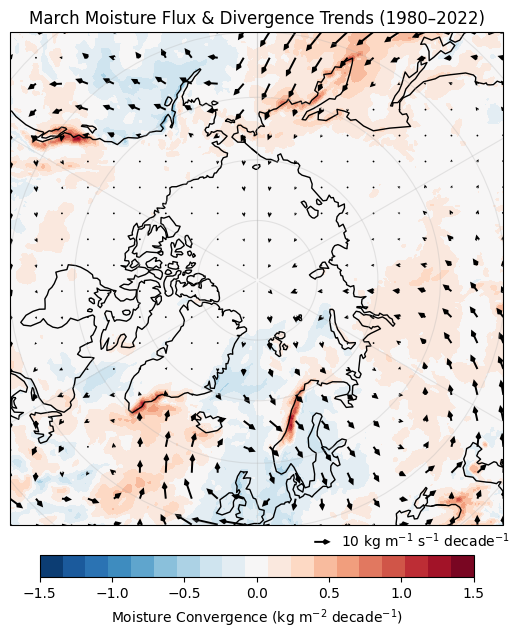

In [5]:
# Plot March
plot_quiver_with_contour_polar(march_trend_east, march_trend_north, march_trend_div, "March")


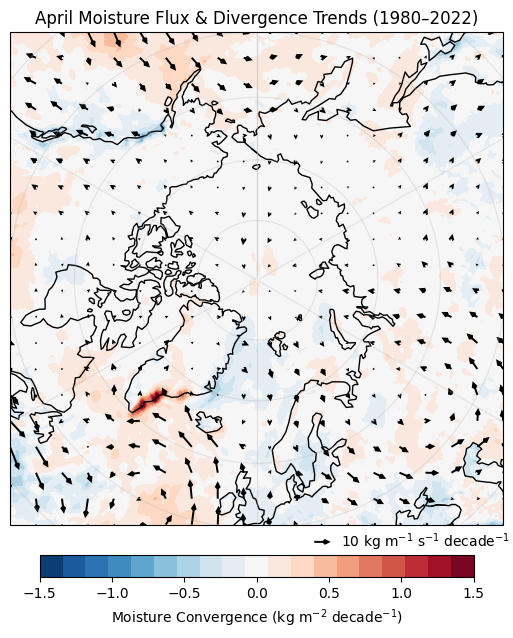

In [6]:
# Plot April
plot_quiver_with_contour_polar(april_trend_east, april_trend_north, april_trend_div, "April")


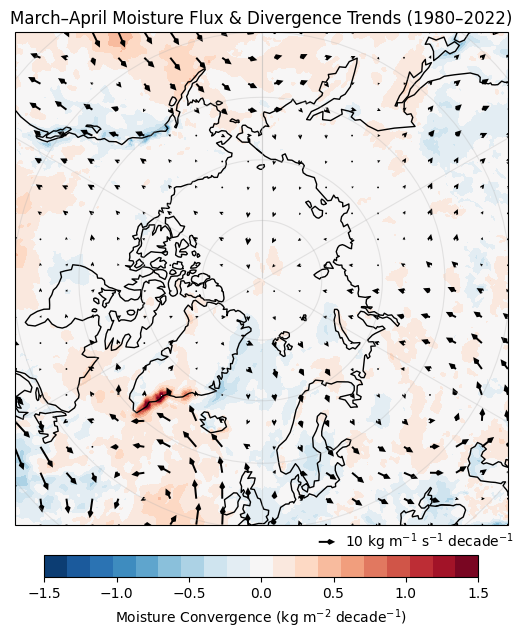

In [7]:
# Plot difference
diff_east = march_trend_east - april_trend_east
diff_north = march_trend_north - april_trend_north
diff_div = march_trend_div - april_trend_div

plot_quiver_with_contour_polar(april_trend_east, april_trend_north, april_trend_div, "March–April")
